# Intersection Risk Analysis Using Satellite Imagery
COMP 4531 – Deep Learning Final Project – Thomas Beadle

#### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image


2024-11-14 20:39:28.881891: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 20:39:29.069848: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Problem Statement: Can a neural network accurately identify dangerous intersections from satellite imagery and crash data?

Traffic fatalities remain a critical public safety concern in the United States, with over 42,000 deaths recorded in 2022 (https://highways.dot.gov/safety/about-safety). While not all of these deaths occured at intersections, these junctions represent concentrated points of risk within the road network. Traditional traffic safety analysis relies on historical crash data and manual assessment, but modern machine learning techniques may offer new insights into identifying dangerous intersection designs before accidents occur.

A neural network may be able to predict dangerous intersections based on satellite imagery by identifying commonalities accross interections with high rates of accidents. It is important to note that there are limitations with using only satalliete imagery as these images do not reflect weather conditions, time of day, past construction, impaired or distracted drivers, or other temporary hazards. This project examines whether the most dangerous intersections share visual features that a Convolutional Neural Network (CNN) can learn to identify. Some hazards may be obvious, like buildings creating blind corners, but the CNN could also identify less apparent patterns useful in predicting high risk intersections.

### Data Collection and Preprocessing Methodology


Accident data came from Denver Open Data Catalog. The set consists of "accident data from the previous five calendar years plus current year to date." https://arcg.is/0zHWPm


Dataset includes 257,299 police traffic accident records from January 2013 through October 2024. Analysis focused on precincts 113 and 111, which is bounded by:

- East/West:
    - Pecos St.
    - Sheridan Rd.
- North/South: 
    - 50th St.
    - 29th St


For the purpose of this project, an intersection is defined as any point at which a road, ramp, or other driving surface merges or crosses another. Only accidents marked as 'Intersection Related', 'At Intersection', 'ROUNDABOUT', 'Ramp Related', or 'Ramp' in the accident data set were considered to exclude highway or other incidents that were within 100 feet of intersections but not related to the nearby intersection.


452 intersections were captured at a zoom of 20, then cropped to 1000x1000 pixels before being reduced to 255 x 255 for training.

![all_intersections](./tf/Intersections.png)

Intersection photo example:

![croppedExample](./tf/cropped_Denver_2.png)


Reduced photo example:

![croppedExample](./tf/Redcrop_Denver_2.png)


After intersection points were identified and screenshots collected, crash locations were compared to all chosen intersections. If a crash was within 100 feet of an intersection (typical city intersection being 50-150 feet), 1 was added to the 'crash_count' column of the dataframe. If a crash was within 100 feet of two or more intersections, the crash was assigned to the closest intersection. In total, 3,523 accidents were attributed to the 452 intersections analyzed.


_All of the above was completed in a separate Jupyter notebook due to TensorFlow's "quirks" with other packages._

### User Defined Functions

In [2]:
def predSample(model):
    #set risk categories for display
    risk_categories = ['Low', 'Med', 'High']

    #get predictions
    predictions = model.predict(X_test)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = np.argmax(y_test, axis=1)

    #randomize images to display
    randImgIndx = np.random.choice(len(X_test), size=9, replace=False)
    plt.figure(figsize=(15, 12))

    #plot 6 images
    for i, indx in enumerate(randImgIndx):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_test[indx])
        plt.axis('off')
        
        pred_risk = risk_categories[predicted_categories[indx]]
        true_risk = risk_categories[true_categories[indx]]
        title = f'Pred: {pred_risk}\nTrue: {true_risk}'
        
        #color code prediction
        color = 'green' if pred_risk == true_risk else 'red'
        plt.title(title, color=color)

    plt.tight_layout()
    plt.show()

def graphPerf(history1, history2=None):

    if history2 is None:
        fig, axs = plt.subplots(2, 1, figsize=(8, 8))

        ax1 = axs[0]
        ax2 = axs[1]

        acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']

        ax1.plot(history1.epoch, acc, color='blue', label="Training")
        ax1.plot(history1.epoch, val_acc, color='red', label="Validation")
        ax1.set_ylabel("Accuracy")

        lossHis = history1.history['loss']
        valLossHis = history1.history['val_loss']
        ax2.plot(history1.epoch, lossHis, color='blue', label='Training')
        ax2.plot(history1.epoch, valLossHis, color= "red", label='Validation')

        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epochs')


    else:
        fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey='row')
        ax1 = axs[0][0]
        ax2 = axs[1][0]
        ax3 = axs[0][1]
        ax4 = axs[1][1]

        acc_model1 = history1.history['accuracy']
        val_acc_model1 = history1.history['val_accuracy']

        lossHis_model1 = history1.history['loss']
        valLossHis_model1 = history1.history['val_loss']

        ax1.plot(history1.epoch, acc_model1, color='blue', label="Training")
        ax1.plot(history1.epoch, val_acc_model1, color='red', label="Validation")

        ax2.plot(history1.epoch, lossHis_model1, color='blue', label='Training')
        ax2.plot(history1.epoch, valLossHis_model1, color= "red", label='Validation')


        acc_model2 = history2.history['accuracy']
        val_acc_model2 = history2.history['val_accuracy']

        ax3.plot(history2.epoch, acc_model2, color='blue', label="Training")
        ax3.plot(history2.epoch, val_acc_model2, color='red', label="Validation")


        lossHis_model2 = history2.history['loss']
        valLossHis_model2 = history2.history['val_loss']
        ax4.plot(history2.epoch, lossHis_model2, color='blue', label='Training')
        ax4.plot(history2.epoch, valLossHis_model2, color= "red", label='Validation')

        ax1.set_title("Model with Augmentation")
        ax3.set_title("Model without Augmentation")
        ax1.set_ylabel("Accuracy")
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epochs')



    ax1.legend()
    ax2.legend()
    plt.show()

### Create Prediction Target

Due to the wide range in crash counts (0-164), monthly crash rates were calculated for better comparison across the 142-month period. To create balanced classes for the prediction target, risk categories were then defined based on monthly crash rate percentiles:

- Low Risk: Bottom 33rd percentile (<0.00704 crashes/month)  
- Medium Risk: 33rd-66th percentile (0.00704-0.03287 crashes/month)
- High Risk: Top 33rd percentile (>0.03287 crashes/month)

In [3]:
intersections = pd.read_csv('IntersectionCrashes.csv')
intersections.describe().T

,count,mean,std,min,25%,50%,75%,max
id,452.0,225.500000,130.625419,0.000000,112.750000,225.500000,338.250000,451.000000
geo_lat,452.0,39.773094,0.008505,39.758399,39.765719,39.772951,39.780218,39.791065
geo_lon,452.0,-105.028868,0.013852,-105.053304,-105.039348,-105.029933,-105.015875,-105.005367
lat,452.0,39.773094,0.008505,39.758399,39.765719,39.772951,39.780218,39.791065
long,452.0,-105.028868,0.013852,-105.053304,-105.039348,-105.029933,-105.015875,-105.005367
crash_count,452.0,7.794248,17.536902,0.000000,0.750000,2.000000,6.000000,164.000000


In [4]:
#assert risk score 
# low (0-0.00704 monthly crash rate) = 1
# med (0.00704-0.03287 monthly crash rate) = 2
# high (0.03287+ monthly crash rate) = 3
def asessRiskScore(value):
    if value < 0.00704:
        return 0
    elif value <= 0.03287:
        return 1
    else:
        return 2

# 142 months
months = 142
intersections['monthly_rate'] = intersections['crash_count']/months

maxCrash = intersections["crash_count"].max()
minCrash = intersections["crash_count"].min()
print(f"Highest number of crashes for an intersection: {maxCrash}")
print(f"Highest number of crashes for an intersection: {minCrash}")
print()
print("33rd percential for crashes and monthly crash rate: ")
print(f"Number crashes: {intersections['crash_count'].quantile(0.33333)}")
print(f"Monthly rate: {intersections['monthly_rate'].quantile(0.33333):.5f}")
print()
print("66th percential for crashes and monthly crash rate: ")
print(f"Number crashes: {intersections['crash_count'].quantile(0.66667)}")
print(f"Monthly rate: {intersections['monthly_rate'].quantile(0.66667):.5f}")
print()

intersections["risk"] = intersections["monthly_rate"].apply(asessRiskScore)

print(intersections.describe().T)
print()
intersections.head()

Highest number of crashes for an intersection: 164
Highest number of crashes for an intersection: 0

33rd percential for crashes and monthly crash rate: 
Number crashes: 1.0
Monthly rate: 0.00704

66th percential for crashes and monthly crash rate: 
Number crashes: 4.668169999999975
Monthly rate: 0.03287

              count        mean         std         min         25%  \
id            452.0  225.500000  130.625419    0.000000  112.750000   
geo_lat       452.0   39.773094    0.008505   39.758399   39.765719   
geo_lon       452.0 -105.028868    0.013852 -105.053304 -105.039348   
lat           452.0   39.773094    0.008505   39.758399   39.765719   
long          452.0 -105.028868    0.013852 -105.053304 -105.039348   
crash_count   452.0    7.794248   17.536902    0.000000    0.750000   
monthly_rate  452.0    0.054889    0.123499    0.000000    0.005282   
risk          452.0    1.084071    0.760449    0.000000    0.750000   

                     50%         75%         max  
id

,id,geo_lat,geo_lon,lat,long,crash_count,monthly_rate,risk
0,0,39.780206,-105.053272,39.780206,-105.053272,27,0.190141,2
1,1,39.778386,-105.053247,39.778386,-105.053247,6,0.042254,2
2,2,39.776601,-105.053269,39.776601,-105.053269,49,0.345070,2
3,3,39.774770,-105.053256,39.774770,-105.053256,9,0.063380,2
4,4,39.782811,-105.006428,39.782811,-105.006428,0,0.000000,0


### Load, combine, and split data

In [5]:
image_dir = 'ReducedCropped2'

image_size=(255, 255)

images = []
risk = []
for index, row in intersections.iterrows():
    
    #get image file path
    imgIndx = int(row["id"])
    img_path = os.path.join(image_dir, f'cropped_Denver_{imgIndx}.png')
    
    #load image
    img = tf.keras.preprocessing.image.load_img(
        img_path, 
        target_size=image_size)

    #convert image to array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    #normalize
    img_array = img_array / 255.0   
    
    #append to list
    images.append(img_array)
    risk.append(row['risk'])
        
#convert lists to arrays
imageArray = np.array(images)
riskArray = np.array(risk)

# split data, stratify to reduce impact of low crash intersections
X_train, X_test, y_train, y_test = train_test_split(imageArray, riskArray, test_size=0.2, random_state=773, stratify=riskArray)  

#convert y to categorical for CNN predictions
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [6]:
#Set up image augmentation generator to use while training to show 
# difference in augmented and non augmented models
imgAug = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1)

## Models from Scratch

In [40]:
evalDict = {}
lossDict = {}

### Base Model: KISS: Keep It Simple Stupid

Let's start off simple and create a model with only three convolutional layers, no dropout and no early stopping to see how it performs.

#### Build & Train Model:

- 3 convolutional layers (filters: 32, 64, 128)
- No dropout
- Early stopping
- Default learning rate (0.001)
- No additional dense layers

In [8]:
#build model for easier repetition
def kissBuild():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())

    model.add(layers.Dense(3, activation='softmax'))

    return model

#call backs for early stopping and model saving
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model_kiss.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]

kiss = kissBuild()

kiss.compile(optimizer='RMSprop',
            loss="categorical_crossentropy",
            metrics=["accuracy"])

kisstory = kiss.fit(imgAug.flow(X_train, y_train, batch_size=16), validation_data=(X_test, y_test), epochs=20, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.3600 - loss: 3.1241 - val_accuracy: 0.3516 - val_loss: 1.0982
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 472ms/step - accuracy: 0.4116 - loss: 1.0914 - val_accuracy: 0.4176 - val_loss: 1.0956
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 493ms/step - accuracy: 0.4477 - loss: 1.1004 - val_accuracy: 0.4176 - val_loss: 1.0772
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 536ms/step - accuracy: 0.4536 - loss: 1.1036 - val_accuracy: 0.4176 - val_loss: 1.0796
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 542ms/step - accuracy: 0.4019 - loss: 1.0766 - val_accuracy: 0.4945 - val_loss: 1.0738
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 510ms/step - accuracy: 0.4165 - loss: 1.1389 - val_accuracy: 0.4176 - val_loss: 1.0720
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 490ms/step - accuracy: 0.4314 - loss: 1.0360 - val_accuracy: 0.2527 - val_loss: 1.1240
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 467ms/step - accuracy: 0.5243 - loss: 0.9793 - val_accuracy: 0.395

In [9]:
tf.keras.backend.clear_session()

#call backs for early stopping and model saving
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model_kiss_noAug.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]

noAugKiss = kissBuild()

noAugKiss.compile(optimizer='RMSprop',
            loss="categorical_crossentropy",
            metrics=["accuracy"])


noAugkisstory = noAugKiss.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16, callbacks=callbacks)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 515ms/step - accuracy: 0.3502 - loss: 3.9716 - val_accuracy: 0.4286 - val_loss: 1.0821
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - accuracy: 0.3821 - loss: 1.1092 - val_accuracy: 0.4176 - val_loss: 1.4103
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step - accuracy: 0.4096 - loss: 1.1636 - val_accuracy: 0.5165 - val_loss: 1.0921
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 466ms/step - accuracy: 0.4946 - loss: 1.0792 - val_accuracy: 0.2967 - val_loss: 1.0964
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 466ms/step - accuracy: 0.5063 - loss: 1.0829 - val_accuracy: 0.4176 - val_loss: 1.2283
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 467ms/step - accuracy: 0.5097 - loss: 1.0691 - val_accuracy: 0.5604 - val_loss: 1.0626
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 0.6748 - loss: 0.8221 - val_accuracy: 0.4066 - val_loss: 1.1263
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - accuracy: 0.7968 - loss: 0.5916 - val_accu

#### Graph Performance

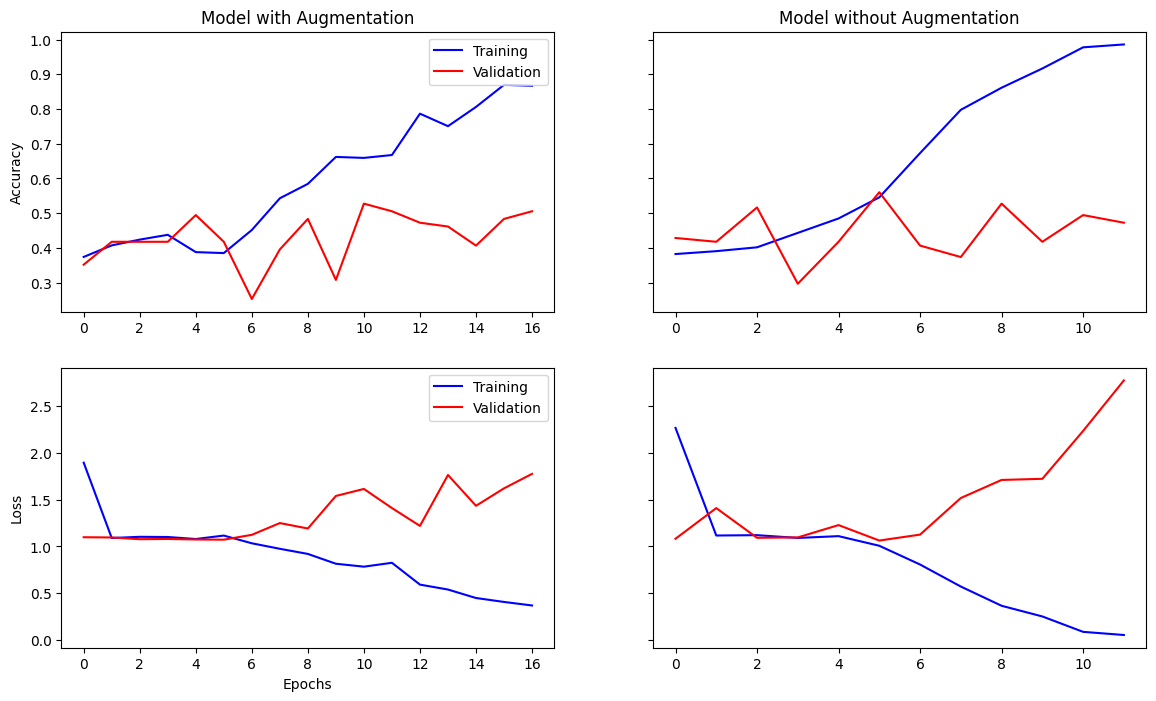

In [71]:
graphPerf(kisstory, noAugkisstory)

bestKiss = max(kisstory.history['val_accuracy'])
evalDict['kiss'] = bestKiss

indx =  kisstory.history['val_accuracy'].index(bestKiss)
bestLoss = kisstory.history['val_loss'][indx]
lossDict['kiss'] = bestLoss

#### Base Model Evaluation

As we can see from the graphs above, both models showed overfitting regardless of data augmentation, starting around epochs 5-6. While training accuracy climbed steadily, validation accuracy struggled to break ~50% for either model. As expected, the validation loss increased steadily as well around the time when overfitting occured, though augmentation helped keep the loss lower compared to the simple model without augmentation. While data augmentation reduced the overfitting severity, it did not generalize well for predicting intersection risk levels.

### Model 2: A Little Complex

Despite the overfitting issues, the validation accuracy performed better than expected at just under 50%. Let's adjust some paramters to see if that addresses overfitting and helps generalization.

#### Build & Train Model

- 4 convolutional layers (filters: 32, 64, 128, 256):
    - Increased depth for feature extraction
- Dropout rate of 0.2:
    - Reduce overfitting by randomly deactivating 20% of neurons
- Early stopping
- Learning Rate of 0.0001
    - Smaller step size for better convergence with limited data
- No additional dense layers

In [13]:
tf.keras.backend.clear_session()

#build model for easier repetition
def lilCmplxBuild():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(3, activation='softmax'))

    return model


#call backs for early stopping and model saving
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model_lilcmplx.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]


lilCmplxMod = lilCmplxBuild()


lilCmplxMod.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
            loss="categorical_crossentropy",
            metrics=["accuracy"])


lilCmplxHis = lilCmplxMod.fit(imgAug.flow(X_train, y_train, batch_size=16), validation_data=(X_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 507ms/step - accuracy: 0.4082 - loss: 1.0842 - val_accuracy: 0.4176 - val_loss: 1.0846
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 610ms/step - accuracy: 0.4301 - loss: 1.0740 - val_accuracy: 0.4176 - val_loss: 1.0759
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 652ms/step - accuracy: 0.4934 - loss: 1.0388 - val_accuracy: 0.4176 - val_loss: 1.0758
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 619ms/step - accuracy: 0.4189 - loss: 1.0872 - val_accuracy: 0.4176 - val_loss: 1.0884
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 625ms/step - accuracy: 0.4216 - loss: 1.0643 - val_accuracy: 0.4176 - val_loss: 1.0678
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 651ms/step - accuracy: 0.5016 - loss: 1.0388 - val_accuracy: 0.4505 - val_loss: 1.0640
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 600ms/step - accuracy: 0.5635 - loss: 1.0249 - val_accuracy: 0.4945 - val_loss: 1.0604
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 617ms/step - accuracy: 0.5436 - loss: 1.0210 - val_accu

In [18]:
tf.keras.backend.clear_session()

#call backs for early stopping and model saving
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model_lilcmplx_noAug.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]

noAuglilCmplxMod = lilCmplxBuild()


noAuglilCmplxMod.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
            loss="categorical_crossentropy",
            metrics=["accuracy"])


noAuglilCmplxHis = noAuglilCmplxMod.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=20, callbacks=callbacks)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - accuracy: 0.3415 - loss: 1.1140 - val_accuracy: 0.4176 - val_loss: 1.0883
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 567ms/step - accuracy: 0.3672 - loss: 1.0887 - val_accuracy: 0.4176 - val_loss: 1.0753
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 473ms/step - accuracy: 0.4340 - loss: 1.0707 - val_accuracy: 0.4176 - val_loss: 1.0755
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 492ms/step - accuracy: 0.4633 - loss: 1.0503 - val_accuracy: 0.4945 - val_loss: 1.0736
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 557ms/step - accuracy: 0.5200 - loss: 1.0316 - val_accuracy: 0.4176 - val_loss: 1.1122
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 565ms/step - accuracy: 0.4821 - loss: 1.0233 - val_accuracy: 0.4176 - val_loss: 1.2885
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 649ms/step - accuracy: 0.5077 - loss: 1.0015 - val_accuracy: 0.3736 - val_loss: 1.0962
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 625ms/step - accuracy: 0.5798 - loss: 0.9818 - val_accu

#### Graph Performance

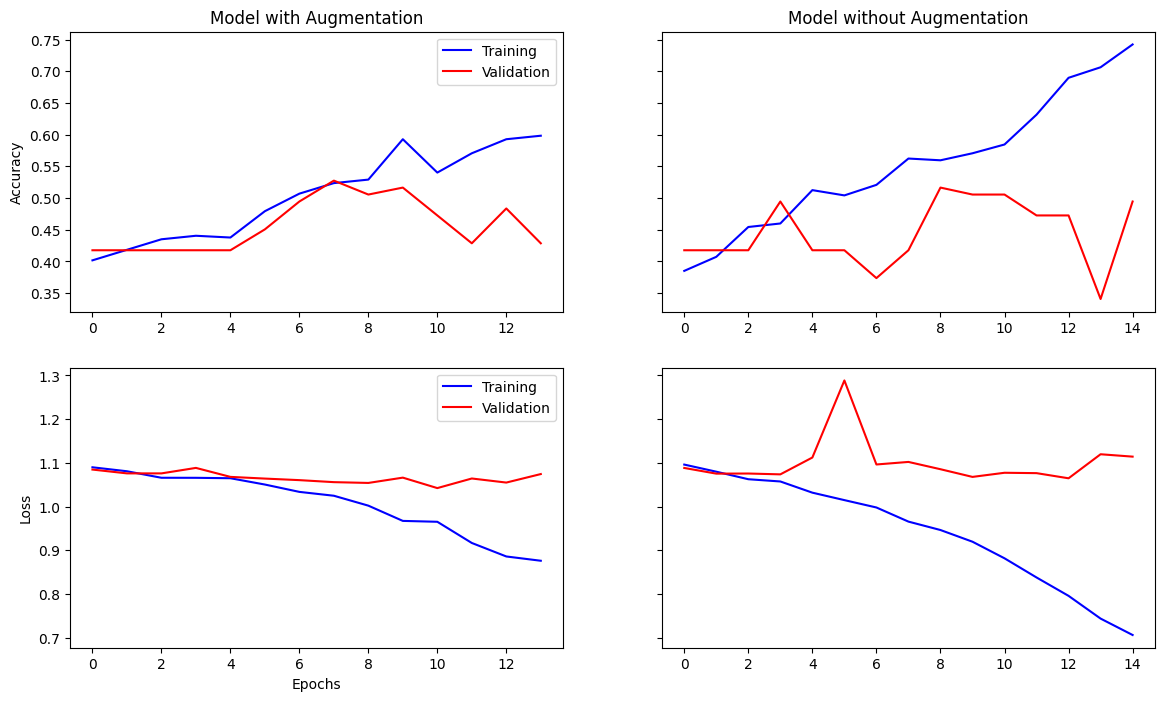

In [70]:
graphPerf(lilCmplxHis, noAuglilCmplxHis)

bestlilCmplx = max(lilCmplxHis.history['val_accuracy'])
evalDict['lilCmplx'] = bestlilCmplx

indx =  lilCmplxHis.history['val_accuracy'].index(bestlilCmplx)
bestLoss = lilCmplxHis.history['val_loss'][indx]
lossDict['lilCmplx'] = bestLoss

#### Model 2 Evaluation

Once again, we see issues with overfitting and the ability to generalize, though the added complexity shows some notable improvements. When combined with data augmentation, the additional layers helped curb overfitting significantly compared to the simpler models. Both models with some complexity added showed steady increases in training accuracy, however, the augmented data model's validation accuracy closely followed its training accuracy up until overfitting began to occur. Interestingly, the loss curves displayed more stability in these models when compared to the base models - while not decreasing, they remain relatively flat on average throughout the training epochs. 

The impact of data augmentation remains particularly noteworthy, as it continues to effectively reduce overfitting across both accuracy and loss metrics. This is evidenced by the narrower gap between training and validation curves compared to non-augmented versions. While the model still struggles with generalization, the combination of increased complexity and data augmentation shows promise for further refinement.

### Model 3: More Complexity

So far, we have managed to reduce overfitting by adding a litte complexity to the model but still struggle improve validation acccuracy beyond ~50%. Let's add more complexity to the previous model to see if that helps improve generalization.

#### Build & Train Model

- 4 convolutional layers (filters: 32, 64, 128, 256)
- Dropout rate of 0.2
- Early stopping
- Learning Rate of 0.0001
- One additional dense filter (filter of 64)
    - Improve model's capacity to learn complex patterns
- Batch normalization in first two convolutional layers
    - Stabilize early feature learning, reducing risk of overfitting

In [49]:
tf.keras.backend.clear_session()

#build model for easier repetition
def cmplxBuild():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(3, activation='softmax'))

    return model

#call backs for early stopping and model saving
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model_mrCmplx.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]

mrCmplx = cmplxBuild()

mrCmplx.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
            loss="categorical_crossentropy",
            metrics=["accuracy"])

mrHis = mrCmplx.fit(imgAug.flow(X_train, y_train, batch_size=16), validation_data=(X_test, y_test), epochs=20, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 747ms/step - accuracy: 0.3516 - loss: 5.1881 - val_accuracy: 0.3297 - val_loss: 1.6491
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 941ms/step - accuracy: 0.5571 - loss: 0.9599 - val_accuracy: 0.3297 - val_loss: 2.2113
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 991ms/step - accuracy: 0.6412 - loss: 0.8428 - val_accuracy: 0.3297 - val_loss: 2.5186
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6686 - loss: 0.7852 - val_accuracy: 0.3297 - val_loss: 1.9067
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7095 - loss: 0.6889 - val_accuracy: 0.3516 - val_loss: 1.6211
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7003 - loss: 0.6712 - val_accuracy: 0.2418 - val_loss: 1.7153
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7862 - loss: 0.5100 - val_accuracy: 0.2527 - val_loss: 2.4663
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 997ms/step - accuracy: 0.8075 - loss: 0.5211 - val_accuracy: 0.2527 - val_loss

In [52]:
tf.keras.backend.clear_session()

#call backs for early stopping and model saving
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model_mrCmplx_noAug.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]

noAugMrCmplx = cmplxBuild()

noAugMrCmplx.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
            loss="categorical_crossentropy",
            metrics=["accuracy"])

noAugMrHis = noAugMrCmplx.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=20, callbacks=callbacks)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 681ms/step - accuracy: 0.3716 - loss: 4.6268 - val_accuracy: 0.3297 - val_loss: 1.1555
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 739ms/step - accuracy: 0.6626 - loss: 0.7349 - val_accuracy: 0.3297 - val_loss: 1.2576
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 976ms/step - accuracy: 0.7288 - loss: 0.6552 - val_accuracy: 0.4505 - val_loss: 1.1514
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8542 - loss: 0.3690 - val_accuracy: 0.3297 - val_loss: 2.2109
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 956ms/step - accuracy: 0.9052 - loss: 0.2623 - val_accuracy: 0.3297 - val_loss: 2.4826
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 961ms/step - accuracy: 0.9571 - loss: 0.1380 - val_accuracy: 0.3297 - val_loss: 1.9479
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 982ms/step - accuracy: 0.9450 - loss: 0.1623 - val_accuracy: 0.3956 - val_loss: 1.9345
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 950ms/step - accuracy: 0.9525 - loss: 0.1202 - val_accurac

#### Graph Performance

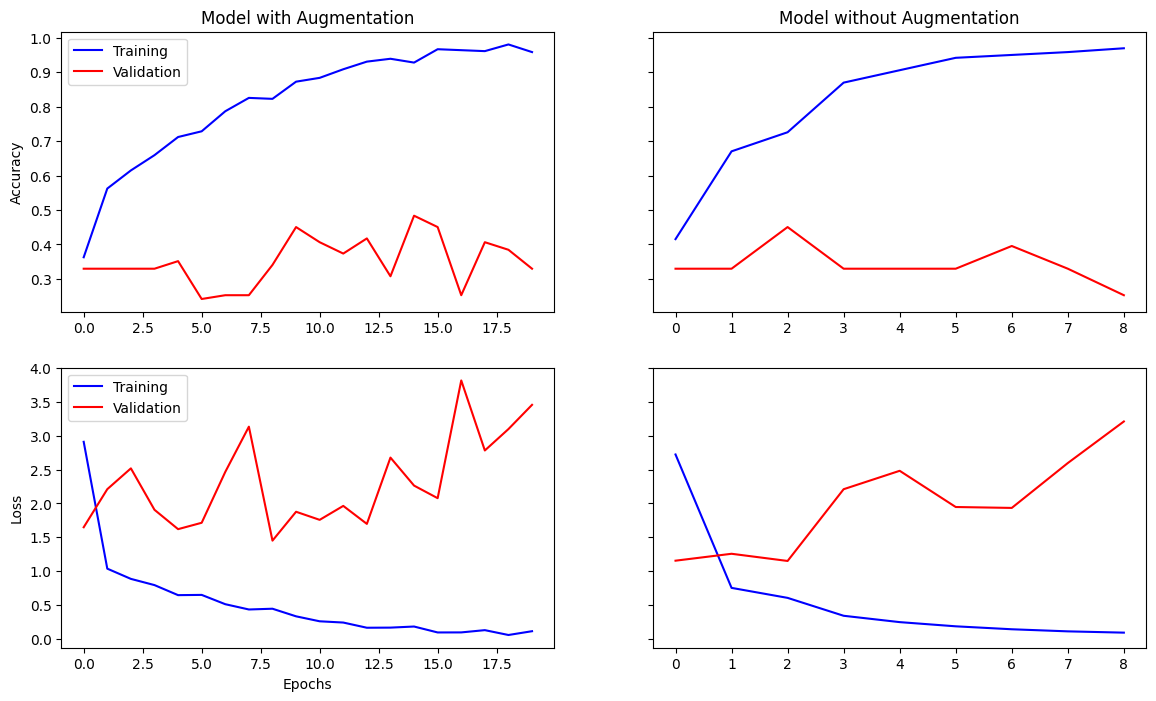

In [69]:
graphPerf(mrHis, noAugMrHis)

bestCmplx = max(mrHis.history['val_accuracy'])
evalDict['lilCmplx'] = bestCmplx

indx =  mrHis.history['val_accuracy'].index(bestCmplx)
bestLoss = mrHis.history['val_loss'][indx]
lossDict['mrCmplx'] = bestLoss

#### Model 3 Evaluation

The most complex model trained from scratch showed the worst performance yet. Both models, with and without augmented data, severely overfit almost immediately, as evidenced by training accuracy nearing 100% while validation accuracies oscillated around the mid-30% range. The validation loss for both models skyrocketed while training loss approached zero in both instances. This clearly indicates that the additional dense layer added too much complexity, while the batch normalization failed to sufficiently curb overfitting.

## Utilizing Pretrained Models

As the augmented data continually showed better performance in regard to overfitting, pretrained models will only be trained on augmented data.

### Pretrained Model 1

#### Import, Build, & Train Model

In [57]:
tf.keras.backend.clear_session()

conv_base  = InceptionV3(
    input_shape = (255, 255, 3),
    weights="imagenet",
    include_top=False)
conv_base.trainable = False  # freeze imagenet weights and biases


inputs = keras.Input(shape=(255, 255, 3))
x = conv_base(inputs)

x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.25)(x)

outputs = layers.Dense(3, activation="softmax")(x) 
pretrained_model1 = keras.Model(inputs, outputs)
pretrained_model1.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"]) 

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="pretrained_1.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
        verbose=1)]

history_pre1 = pretrained_model1.fit(
    imgAug.flow(X_train,
    y_train),
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=callbacks)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3563 - loss: 1.6917 - val_accuracy: 0.3626 - val_loss: 1.2605
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4536 - loss: 1.3476 - val_accuracy: 0.4176 - val_loss: 1.2868
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5064 - loss: 1.1819 - val_accuracy: 0.4066 - val_loss: 1.2448
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5756 - loss: 0.9459 - val_accuracy: 0.4615 - val_loss: 1.3251
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6600 - loss: 0.8564 - val_accuracy: 0.4066 - val_loss: 1.2715
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6586 - loss: 0.7650 - val_accuracy: 0.4286 - val_loss: 1.2380
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7094 - loss: 0.7064 - val_accuracy: 0.4396 - val_loss: 1.2564
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7429 - loss: 0.5940 - val_accuracy: 0.4286 - val_loss:

#### Graph Performance

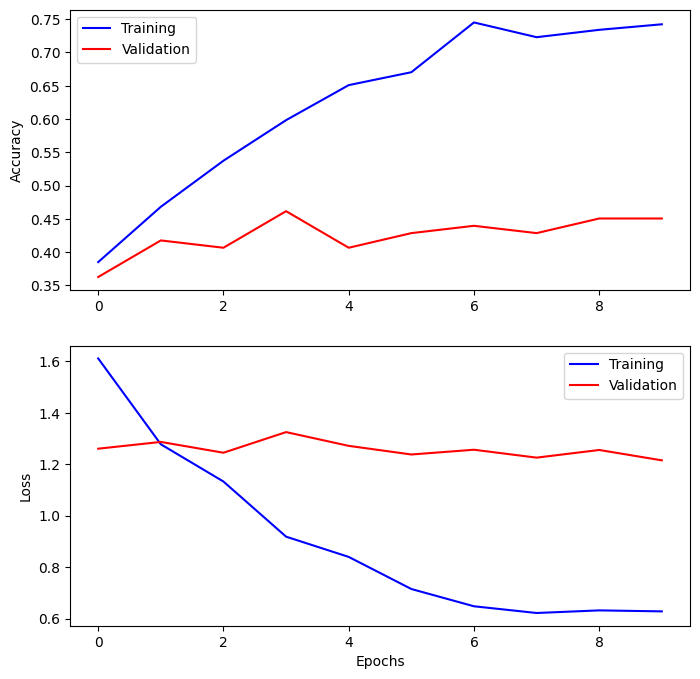

In [68]:
graphPerf(history_pre1)

bestPre = max(history_pre1.history['val_accuracy'])
evalDict['InceptionV3'] = bestPre

indx =  history_pre1.history['val_accuracy'].index(bestPre)
bestLoss = history_pre1.history['val_loss'][indx]
lossDict['InceptionV3'] = bestLoss

### Pretrained Model 2

#### Import, Build, & Train Model

In [59]:
tf.keras.backend.clear_session()

conv_base2  = EfficientNetB0(
    input_shape = (255, 255, 3), 
    weights="imagenet",
    include_top=False)
conv_base2.trainable = False  # freeze imagenet weights and biases


inputs = keras.Input(shape=(255, 255, 3))
x = conv_base2(inputs)

x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.25)(x)


outputs = layers.Dense(3, activation="softmax")(x)     # only the weights in the dense layers will be trained
pretrained_model2 = keras.Model(inputs, outputs)

pretrained_model2.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=["accuracy"]) 



callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="pretrained_2.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
        verbose=1)]

# Train the model
history_pre2 = pretrained_model2.fit(
    imgAug.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 778ms/step - accuracy: 0.2912 - loss: 9.0020 - val_accuracy: 0.3297 - val_loss: 7.8749
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 676ms/step - accuracy: 0.3304 - loss: 5.9387 - val_accuracy: 0.2527 - val_loss: 4.7860
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 688ms/step - accuracy: 0.2884 - loss: 5.2967 - val_accuracy: 0.4176 - val_loss: 2.2355
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 655ms/step - accuracy: 0.3752 - loss: 4.2353 - val_accuracy: 0.3297 - val_loss: 4.8236
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 669ms/step - accuracy: 0.3516 - loss: 3.9464 - val_accuracy: 0.2527 - val_loss: 4.9595
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 567ms/step - accuracy: 0.3199 - loss: 4.9755 - val_accuracy: 0.3297 - val_loss: 3.4127
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 676ms/step - accuracy: 0.3240 - loss: 5.1452 - val_accuracy: 0.4176 - val_loss: 2.2429
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 629ms/step - accuracy: 0.3319 - loss: 4.5804 - val_accu

#### Graph Performance

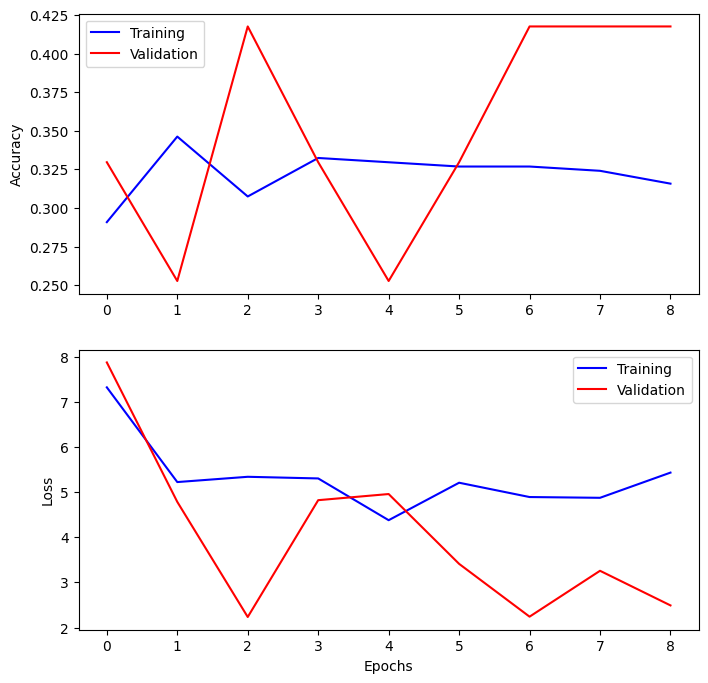

In [66]:
graphPerf(history_pre2)

bestPre = max(history_pre2.history['val_accuracy'])
evalDict['EfficientNetB0'] = bestPre

indx =  history_pre2.history['val_accuracy'].index(bestPre)
bestLoss = history_pre2.history['val_loss'][indx]
lossDict['EfficientNetB0'] = bestLoss

### Pretrained Model 3

#### Import, Build, & Train Model

In [61]:
# ResNet50V2
tf.keras.backend.clear_session()

conv_base3  = ResNet50V2(
    input_shape = (255, 255, 3), #was not included in homwork
    weights="imagenet",
    include_top=False)
conv_base3.trainable = False  # freeze imagenet weights and biases 

tf.keras.backend.clear_session()
inputs = keras.Input(shape=(255, 255, 3))
x = conv_base3(inputs)

x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.25)(x)


outputs = layers.Dense(3, activation="softmax")(x)     # only the weights in the dense layers will be trained
pretrained_model3 = keras.Model(inputs, outputs)

pretrained_model3.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=["accuracy"]) 




callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="pretrained_2.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
        verbose=1)
]


history_pre3 = pretrained_model3.fit(
    imgAug.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.3947 - loss: 8.3467 - val_accuracy: 0.3077 - val_loss: 13.2930
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6207 - loss: 3.5843 - val_accuracy: 0.4615 - val_loss: 9.3316
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7123 - loss: 2.4065 - val_accuracy: 0.3516 - val_loss: 8.8674
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8055 - loss: 1.0704 - val_accuracy: 0.3956 - val_loss: 6.4402
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8627 - loss: 1.0741 - val_accuracy: 0.4176 - val_loss: 5.5369
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8783 - loss: 0.6190 - val_accuracy: 0.3516 - val_loss: 6.3918
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9010 - loss: 0.8700 - val_accuracy: 0.4505 - val_loss: 6.0886
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9594 - loss: 0.1501 - val_accuracy: 0.4615 - val_loss

#### Graph Performance

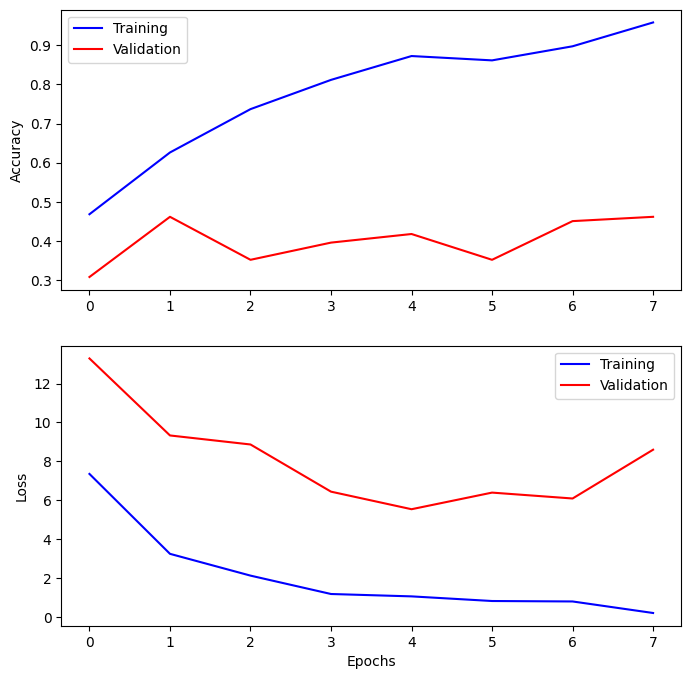

In [67]:
graphPerf(history_pre3)

bestPre = max(history_pre3.history['val_accuracy'])
evalDict['ResNet50V2'] = bestPre

indx =  history_pre3.history['val_accuracy'].index(bestPre)
bestLoss = history_pre3.history['val_loss'][indx]
lossDict['ResNet50V2'] = bestLoss

### Pretrained Models Evaluations

Unfortunately, all pretrained models performed poorly. With the exception of EfficientNetB0, each model displayed significant overfitting. While EfficientNetB0 did not appear to overfit, it performed poorly on training data (~33%), no better than random guessing with three categories. Even though EfficientNetB0's validation accuracy ended above its training accuracy, ~40% does not indicate good generalization. Adding more layers and increasing dropout might help address these issues; however, it's also possible that these pretrained models are poorly suited for predicting outcomes from satellite imagery. Various iterations with different additional layers and filter sizes ranging from 64 to 256 were tested, but each displayed similar issues. Due to time constraints, only the simplest models were presented.

## Model Comparison

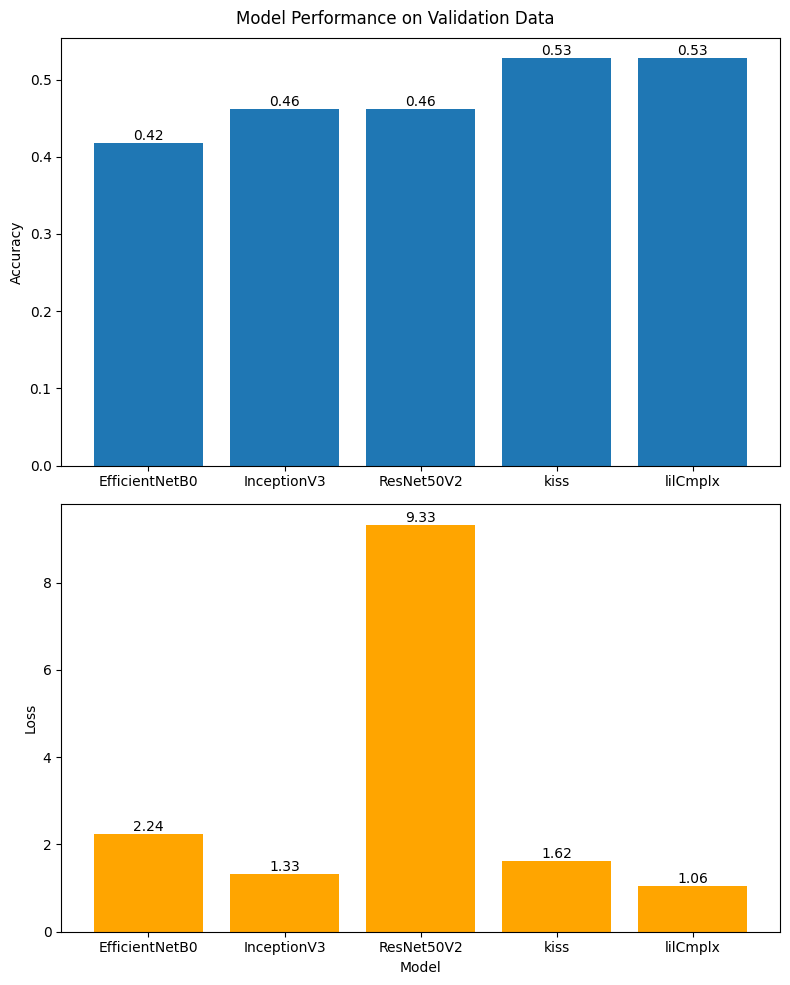

In [76]:
getLabels = sorted(set(evalDict.keys()) & set(lossDict.keys()))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

accuracies = [evalDict[label] for label in getLabels]
losses = [lossDict[label] for label in getLabels]

g1 = ax1.bar(getLabels, accuracies, label="Accuracy")
g2 = ax2.bar(getLabels, losses, color='orange', label="Loss")

for bar in g1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

for bar in g2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')
ax2.set_xlabel("Model")
fig.suptitle("Model Performance on Validation Data")

plt.tight_layout()
plt.show()

## Winning Model Predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


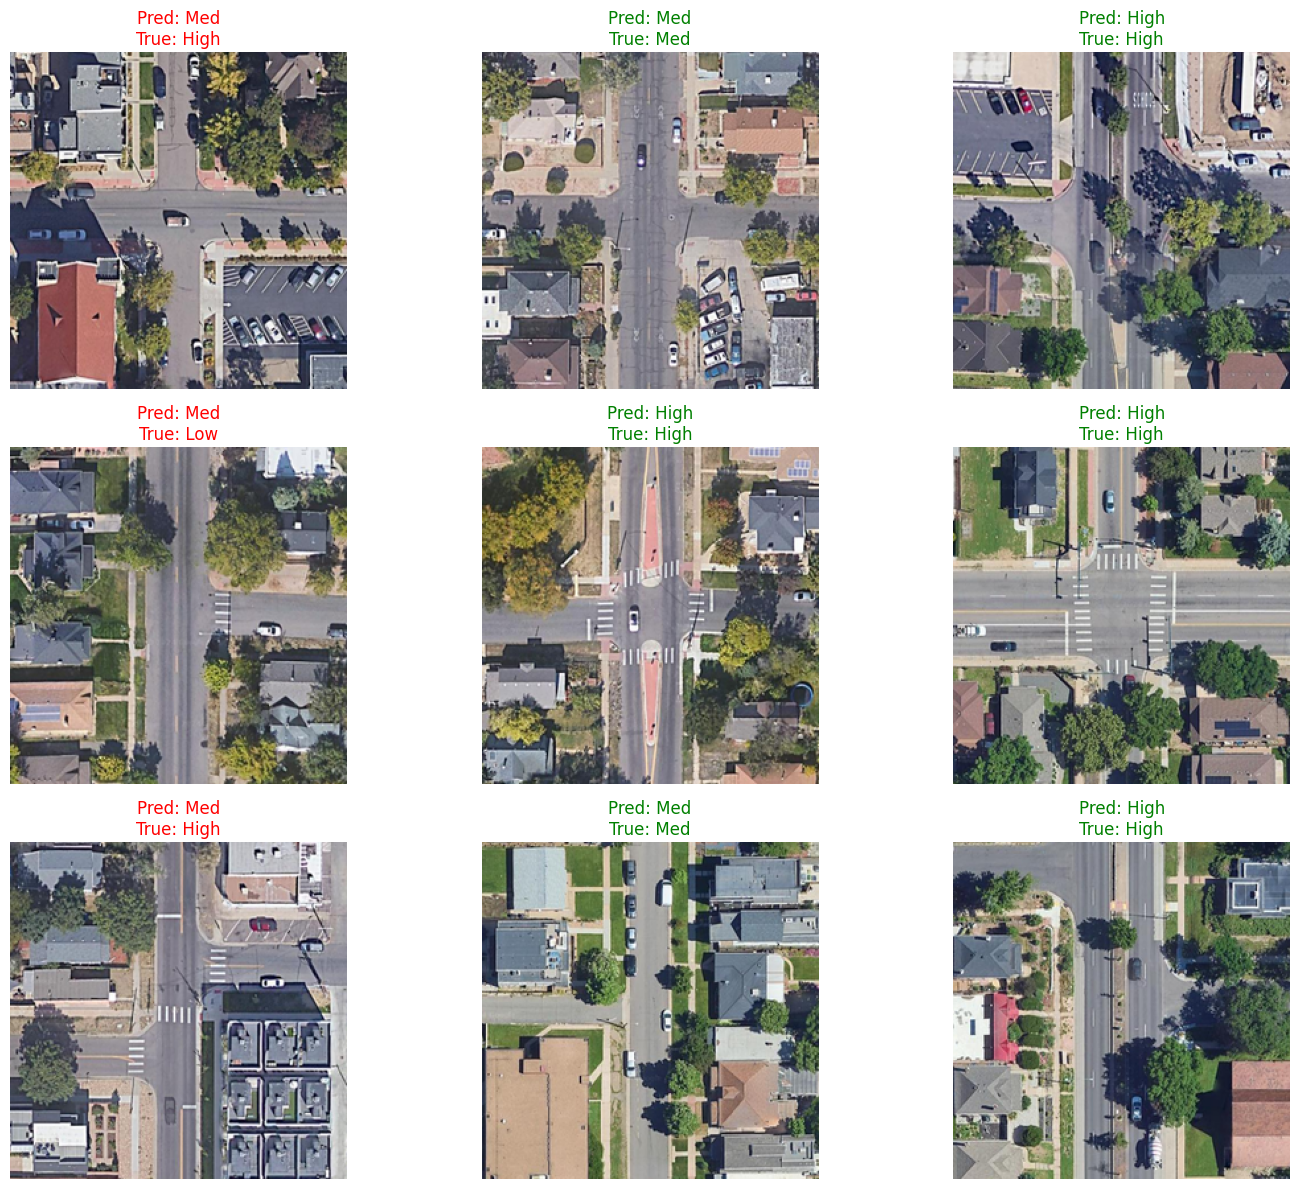

In [77]:
predSample(lilCmplxMod)